In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Carregar dados
data = pd.read_csv('./15kVA/Transformer (Damage Curve).csv')
time = data['transformer/primaryAmps'].values.reshape(-1, 1)
current = data['transformer/primarySeconds'].values

# Transformar para escala logarítmica
X_log = np.log(time)
y_log = np.log(current)

# Normalizar os dados (importante para redes neurais)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_log_scaled = scaler_X.fit_transform(X_log)
y_log_scaled = scaler_y.fit_transform(y_log.reshape(-1, 1))

# Converter para tensores do PyTorch
X_tensor = torch.tensor(X_log_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_log_scaled, dtype=torch.float32)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [3]:
# Definir a MLP
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.layers(x)

# Inicializar modelo, loss e otimizador
model = MLP(input_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Treinamento
epochs = 1000
train_losses = []
test_losses = []

for epoch in range(epochs):
    # Modo de treino
    model.train()
    optimizer.zero_grad()

    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    # Backward pass
    loss.backward()
    optimizer.step()

    # Avaliar no teste
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)

    train_losses.append(loss.item())
    test_losses.append(test_loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.4f}, Test Loss: {test_loss.item():.4f}')

Epoch [100/1000], Train Loss: 0.0116, Test Loss: 0.0104
Epoch [200/1000], Train Loss: 0.0024, Test Loss: 0.0023
Epoch [300/1000], Train Loss: 0.0006, Test Loss: 0.0007
Epoch [400/1000], Train Loss: 0.0004, Test Loss: 0.0004
Epoch [500/1000], Train Loss: 0.0003, Test Loss: 0.0003
Epoch [600/1000], Train Loss: 0.0002, Test Loss: 0.0002
Epoch [700/1000], Train Loss: 0.0002, Test Loss: 0.0001
Epoch [800/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [900/1000], Train Loss: 0.0001, Test Loss: 0.0001
Epoch [1000/1000], Train Loss: 0.0001, Test Loss: 0.0001


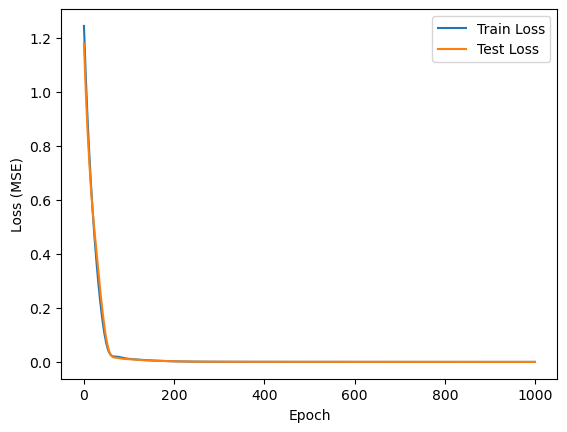

In [4]:

# Plotar perdas
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [5]:

# Fazer previsões
model.eval()
with torch.no_grad():
    y_pred_scaled = model(X_test).numpy()

# Reverter a normalização
y_pred_log = scaler_y.inverse_transform(y_pred_scaled)
X_test_log = scaler_X.inverse_transform(X_test.numpy())

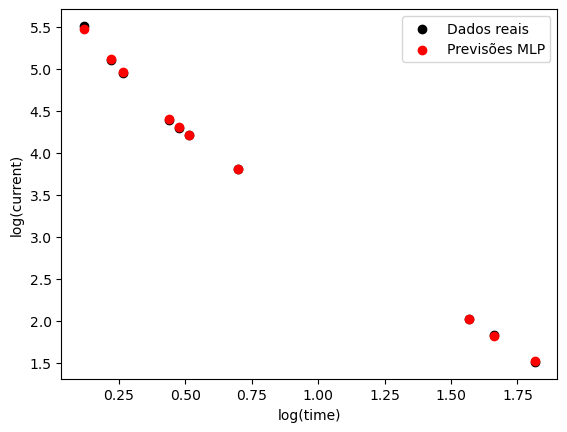

In [6]:

# Plotar resultados
plt.scatter(X_test_log, scaler_y.inverse_transform(y_test.numpy()), color='black', label='Dados reais')
plt.scatter(X_test_log, y_pred_log, color='red', label='Previsões MLP')
plt.xlabel('log(time)')
plt.ylabel('log(current)')
plt.legend()
plt.show()

In [7]:
# Converter previsões e dados reais para escala original (opcional)
y_pred_original = np.exp(y_pred_log)
y_test_original = np.exp(scaler_y.inverse_transform(y_test.numpy()))

# Calcular erros em escala logarítmica
mae_log = np.mean(np.abs(y_pred_log - scaler_y.inverse_transform(y_test.numpy())))
rmse_log = np.sqrt(np.mean((y_pred_log - scaler_y.inverse_transform(y_test.numpy()))**2))

# Calcular erros em escala original (se necessário)
mae_original = np.mean(np.abs(y_pred_original - y_test_original))
rmse_original = np.sqrt(np.mean((y_pred_original - y_test_original)**2))

print(f'MAE (log): {mae_log:.4f}')
print(f'RMSE (log): {rmse_log:.4f}')
print(f'MAE (original): {mae_original:.4f}')
print(f'RMSE (original): {rmse_original:.4f}')

MAE (log): 0.0089
RMSE (log): 0.0127
MAE (original): 1.3319
RMSE (original): 2.6793


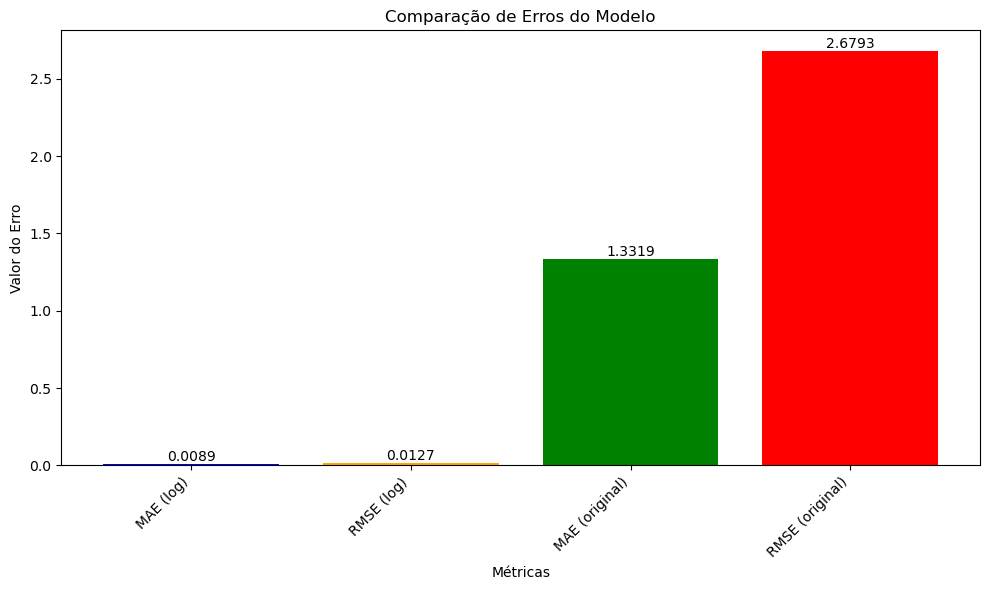

In [8]:
# Dados para o gráfico
metrics = ['MAE (log)', 'RMSE (log)', 'MAE (original)', 'RMSE (original)']
values = [mae_log, rmse_log, mae_original, rmse_original]

# Criar gráfico de barras
plt.figure(figsize=(10, 6))
bars = plt.bar(metrics, values, color=['blue', 'orange', 'green', 'red'])

# Adicionar rótulos e título
plt.xlabel('Métricas')
plt.ylabel('Valor do Erro')
plt.title('Comparação de Erros do Modelo')
plt.xticks(rotation=45, ha='right')

# Adicionar valores nas barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

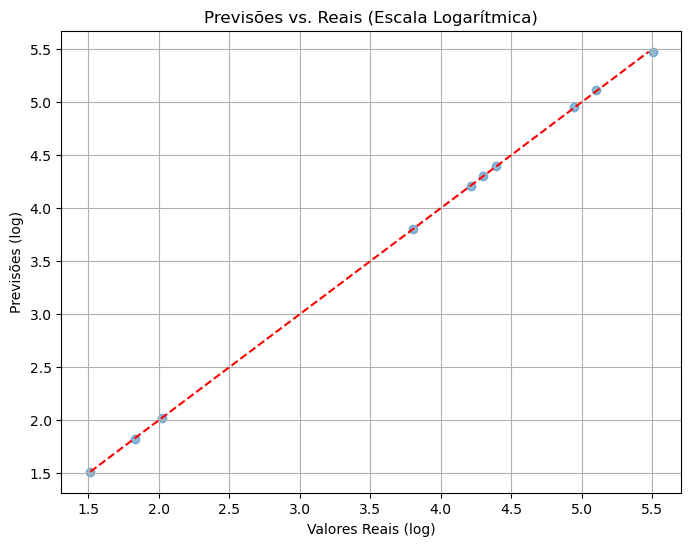

In [9]:
# Plotar previsões vs. reais (escala log)
plt.figure(figsize=(8, 6))
plt.scatter(scaler_y.inverse_transform(y_test.numpy()), y_pred_log, alpha=0.5)
plt.plot([min(y_pred_log), max(y_pred_log)], [min(y_pred_log), max(y_pred_log)], '--r')
plt.xlabel('Valores Reais (log)')
plt.ylabel('Previsões (log)')
plt.title('Previsões vs. Reais (Escala Logarítmica)')
plt.grid(True)
plt.show()